# Lecture 13 Time series Analysis

## What is a time series?

Some data changes over time. We can list many examples in the field of environmental science, such as the hourly/daily temperature in Madison, the monthly CO2 concentration record measured at Mauna Loa, the daily new COVID cases in Wisconsin since 2020.

A time series is just a sequence of time-dependent data.

## What is a time series analysis?

Time Series Analysis is the way of studying the characteristics of the response variable with respect to time, as the independent variable. To estimate the target variable in the name of predicting or forecasting, use the time variable as the point of reference. 

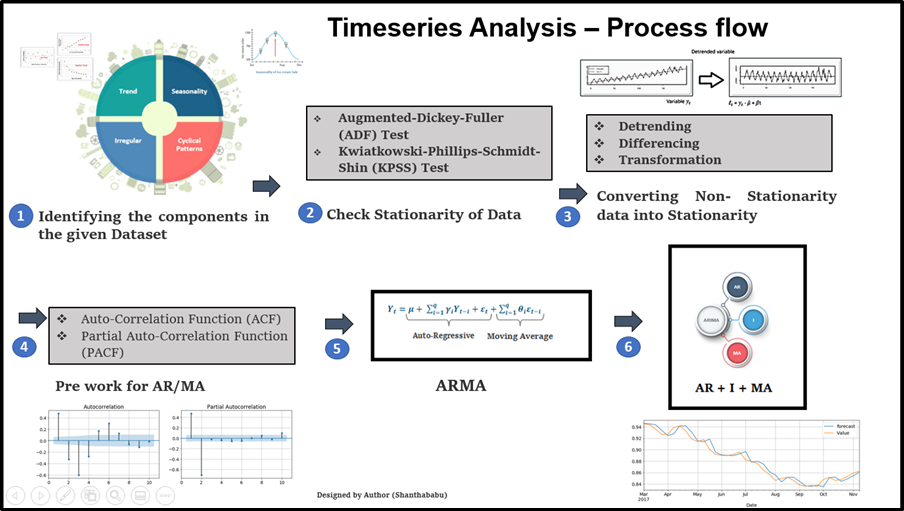

### one important component of time series analysis is forecasting
### - Visualize time series data
### - Moving average
### - decomposition
### - Stationary vs non-stationary
### - forescasting

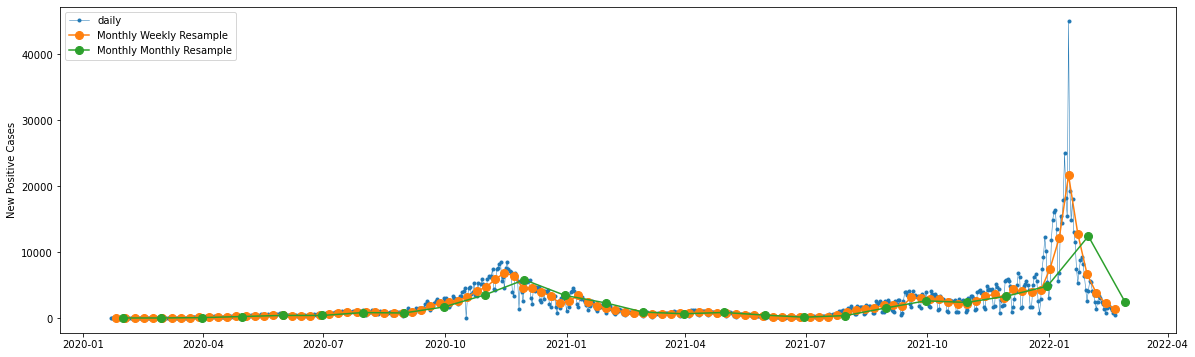

In [37]:
# Visualize time series data

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

covid = pd.read_csv("COVID19-Historical-V2-ST.csv")
covid = covid[["Date", "POS_NEW_CP"]]

# date index
covid['Date'] = pd.to_datetime(covid['Date'])
covid = covid.set_index('Date')

fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(covid.POS_NEW_CP, marker='.', linestyle='-', linewidth=0.5, label='daily')
ax.plot(covid.POS_NEW_CP.resample('W').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Weekly Resample')
ax.plot(covid.POS_NEW_CP.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Monthly Resample')
ax.set_ylabel('New Positive Cases')
ax.legend()

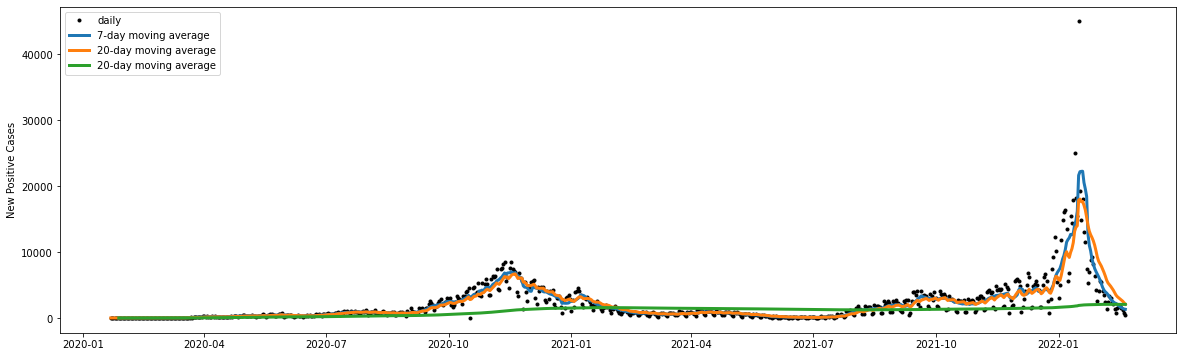

In [35]:
# Moving average


fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(covid.POS_NEW_CP, 'k.', label='daily')

# simple moving average (SMA)
ax.plot(covid.POS_NEW_CP.rolling(7).mean(), linestyle='-', linewidth=3, label='7-day moving average')

# Exponential Moving Average (EMA) - weights added
ax.plot(covid.POS_NEW_CP.ewm(7).mean(), linestyle='-', linewidth=3, label='20-day moving average')

# Cumulative Moving Average (EMA) - the width of the window increases as duration increases
ax.plot(covid.POS_NEW_CP.expanding(7).mean(), linestyle='-', linewidth=3, label='20-day moving average')

ax.set_ylabel('New Positive Cases')
ax.legend()

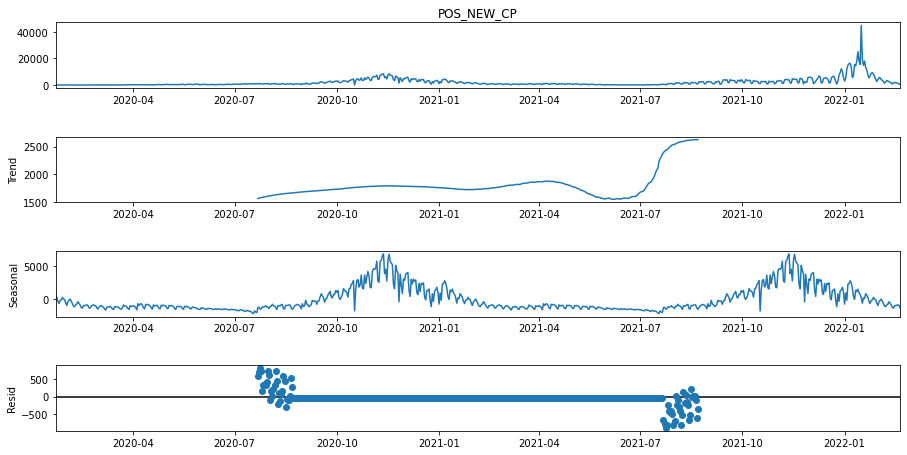

In [20]:
# decomposition

import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(covid.POS_NEW_CP, model='additive', period=365)
fig = decomposition.plot()
fig.set_size_inches(14,7)

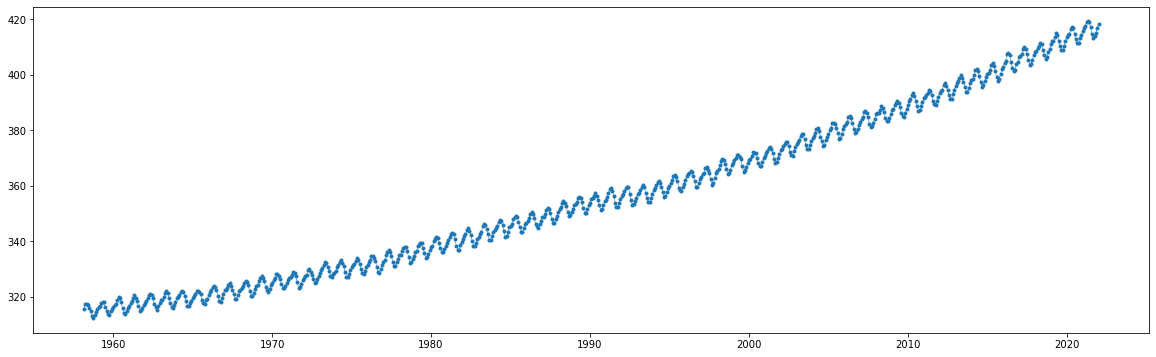

In [52]:
# do decomposition with the Maula Loa CO2 data

co2 = pd.read_csv("co2_mm_mlo.csv", parse_dates= {"date" : ["year","month"]}, comment="#")
co2 = co2.set_index("date")
co2

fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(co2.average, marker='.', linestyle='-', linewidth=0.5, label='daily')

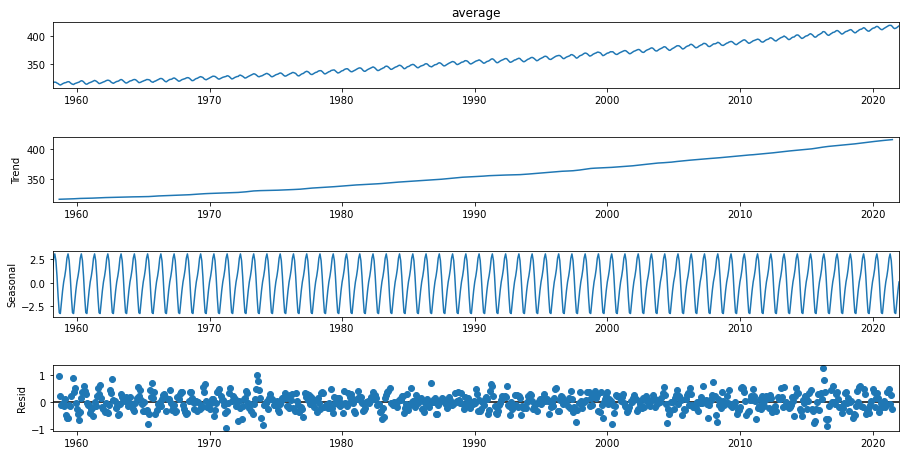

In [53]:
decomposition = sm.tsa.seasonal_decompose(co2.average, model='additive', period=12)
fig = decomposition.plot()
fig.set_size_inches(14,7)

### Stationary and non-stationary time series

- Stationarity means that the statistical properties of a time series (or rather the process generating it) do not change over time.
  - The MEAN value of them should be completely constant in the data during the analysis
  - The VARIANCE should be constant with respect to the time-frame
  - The COVARIANCE measures the relationship between two variables.
- Stationarity is important because many useful analytical tools and statistical tests and models rely on it.
- Non-stationary: the opposite of Stationary.

#### Check the stationarity of your data
- by visualize it
- statistical test
    - Augmented Dickey-Fuller (ADF) Test
    - Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test
    
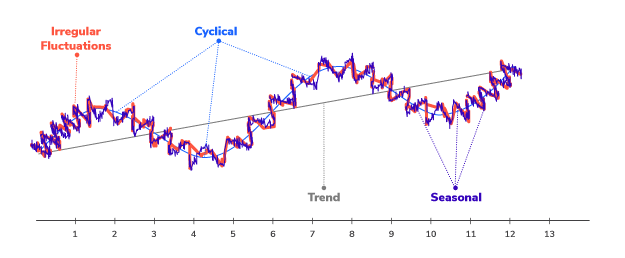
from https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-one/


In [75]:
# ADF test
from statsmodels.tsa.stattools import adfuller

result = adfuller(co2.average)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1]) # if p> 0.05 Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.


from statsmodels.tsa.stattools import kpss
result = kpss(co2.average)
print('KPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1]) # if p < 0.05 non-stationary.


ADF Statistic: 5.452249
p-value: 1.000000
KPSS Statistic: 3.697263
p-value: 0.010000


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


### Make the Data Stationary
To proceed with our time series analysis, we need to stationarize the dataset. There are many approaches to stationarize data, but we’ll use de-trending, differencing, and then a combination of the two.

 > Is the de-trended data stationary ?
Test statistic = -4.632
P-value = 0.000
Critical values :
	1%: -3.4392782790913206 - The data is  stationary with 99% confidence
	5%: -2.865480319267325 - The data is  stationary with 95% confidence
	10%: -2.568868260909806 - The data is  stationary with 90% confidence


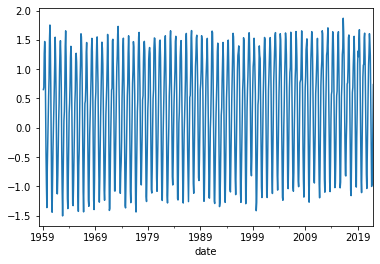

In [78]:
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

# detrending
y = co2.average
y_detrend = (y - y.rolling(window=12).mean())/y.rolling(window=12).std()

y_detrend.plot()
y_detrend.dropna(inplace=True)
result = ADF_test(y_detrend,'de-trended data')

 > Is the 12 lag differenced data stationary ?
Test statistic = -3.542
P-value = 0.007
Critical values :
	1%: -3.4392057325732104 - The data is  stationary with 99% confidence
	5%: -2.8654483492874236 - The data is  stationary with 95% confidence
	10%: -2.5688512291811225 - The data is  stationary with 90% confidence


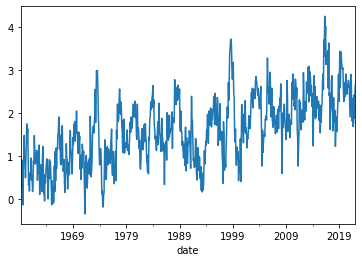

In [79]:
# differencing

# This method removes the underlying seasonal or cyclical patterns in the time series. 
y_12lag =  y - y.shift(12)
y_12lag.dropna(inplace=True)
y_12lag.plot()
ADF_test(y_12lag, '12 lag differenced data')


 > Is the 12 lag differenced de-trended data stationary ?
Test statistic = -9.353
P-value = 0.000
Critical values :
	1%: -3.4393520240470554 - The data is  stationary with 99% confidence
	5%: -2.8655128165959236 - The data is  stationary with 95% confidence
	10%: -2.5688855736949163 - The data is  stationary with 90% confidence


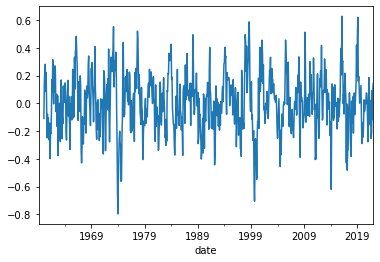

In [82]:
# Detrending + Differencing

y_12lag_detrend =  y_detrend - y_detrend.shift(12)
y_12lag_detrend.plot()
ADF_test(y_12lag_detrend,'12 lag differenced de-trended data')

### Auto-correlation
Auto correlation is used to indicate and how similar a value is within a given time series and the previous value. It measures the degree of the similarity between a given time series and the lagged version of that time series at different intervals that we observed.
Python Statsmodels library calculates autocorrelation. This is used to identify a set of trends in the given dataset and the influence of former observed values on the currently observed values.

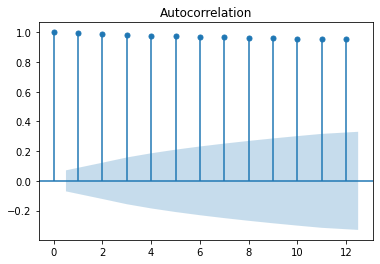

In [96]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(co2.average.values.squeeze(), lags=12)
plt.show()


### Auto Regressive
An AR model is a Linear Regression model, that uses lagged variables as input.
$$Y_t=C+b_1Y_{t-1}+b_2Y_{t-2}+…+b_pY_{t-p}+Er_t$$
- p=past values
- Y_t=Function of different past values
- Er_t=errors in time
- C=intercept

Coefficients: intercept     -0.850344
average.L1     0.774594
average.L2     0.033697
average.L3    -0.010158
average.L4     0.013811
average.L5     0.069670
average.L6     0.049363
average.L7    -0.073907
average.L8    -0.062960
average.L9     0.020434
average.L10   -0.020292
average.L11    0.309842
average.L12    0.301392
average.L13   -0.153264
average.L14   -0.193835
average.L15   -0.056635
average.L16   -0.045538
average.L17   -0.033238
average.L18    0.080893
average.L19   -0.082415
average.L20    0.081747
dtype: float64


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


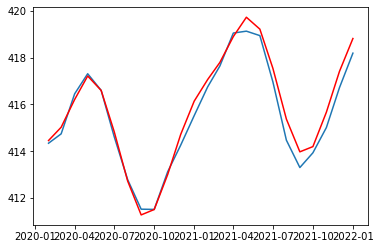

In [100]:
# implementing AR model
from statsmodels.tsa.ar_model import AutoReg

X = co2.average
train, test = X[1:len(X)-24], X[len(X)-24:]

# train autoregression
model = AutoReg(train, lags=20)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)

# Predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

# plot results
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

### ARMA and ARIMA

ARMA: a combination of the Auto-Regressive and Moving Average model for forecasting. This model provides a weakly stationary stochastic process in terms of two polynomials, one for the Auto-Regressive and the second for the Moving Average.
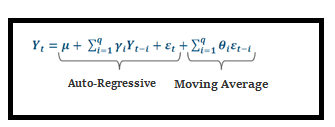

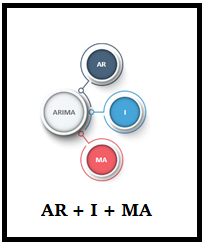

from https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-to-time-series-analysis/

#### Implementation steps for ARIMA
- Step 1: Plot a time series format
- Step 2: Difference to make stationary on mean by removing the trend
- Step 3: Make stationary by applying log transform.
- Step 4: Difference log transform to make as stationary on both statistic mean and variance
- Step 5: Plot ACF & PACF, and identify the potential AR and MA model
- Step 6: Discovery of best fit ARIMA model
- Step 7: Forecast/Predict the value, using the best fit ARIMA model
- Step 8: Plot ACF & PACF for residuals of the ARIMA model, and ensure no more information is left.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS wi

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.81959D-01    |proj g|=  1.88618D+00


 This problem is unconstrained.



At iterate    5    f=  3.81825D-01    |proj g|=  8.81187D-02

At iterate   10    f=  3.81683D-01    |proj g|=  9.59273D-02

At iterate   15    f=  3.81456D-01    |proj g|=  2.34777D-01

At iterate   20    f=  3.79440D-01    |proj g|=  9.05785D-02

At iterate   25    f=  3.79260D-01    |proj g|=  2.17462D-01

At iterate   30    f=  3.79224D-01    |proj g|=  5.09281D-02

At iterate   35    f=  3.78801D-01    |proj g|=  3.11940D+00

At iterate   40    f=  3.78488D-01    |proj g|=  7.96213D-02

At iterate   45    f=  3.77950D-01    |proj g|=  1.16144D+00

At iterate   50    f=  3.77688D-01    |proj g|=  5.43648D-02

At iterate   55    f=  3.77639D-01    |proj g|=  3.09509D-02

At iterate   60    f=  3.77633D-01    |proj g|=  9.48812D-02

At iterate   65    f=  3.77609D-01    |proj g|=  3.92410D-01

At iterate   70    f=  3.77583D-01    |proj g|=  3.86642D-02

At iterate   75    f=  3.77556D-01    |proj g|=  1.17703D-01

At iterate   80    f=  3.77500D-01    |proj g|=  3.71830D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  230    f=  3.74805D-01    |proj g|=  1.31969D+00

At iterate  235    f=  3.74757D-01    |proj g|=  1.76475D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  240    f=  3.74748D-01    |proj g|=  1.48297D-01

At iterate  245    f=  3.74746D-01    |proj g|=  4.63595D-01
  ys=-7.463E-05  -gs= 2.751E-05 BFGS update SKIPPED

At iterate  250    f=  3.74682D-01    |proj g|=  1.95591D+00

At iterate  255    f=  3.74670D-01    |proj g|=  5.52305D-01

At iterate  260    f=  3.74651D-01    |proj g|=  1.18945D+00

At iterate  265    f=  3.74646D-01    |proj g|=  5.76151D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  270    f=  3.74645D-01    |proj g|=  7.55795D-02

At iterate  275    f=  3.74644D-01    |proj g|=  8.41908D-01

At iterate  280    f=  3.74637D-01    |proj g|=  6.01078D-02

At iterate  285    f=  3.74636D-01    |proj g|=  5.54511D-02

At iterate  290    f=  3.74634D-01    |proj g|=  1.83435D-01

At iterate  295    f=  3.74623D-01    |proj g|=  5.75719D-01

At iterate  300    f=  3.74597D-01    |proj g|=  1.03847D-01

At iterate  305    f=  3.74559D-01    |proj g|=  3.56697D-01

At iterate  310    f=  3.74559D-01    |proj g|=  1.75207D-01

At iterate  315    f=  3.74558D-01    |proj g|=  4.11276D-02

At iterate  320    f=  3.74548D-01    |proj g|=  2.30775D+00

At iterate  325    f=  3.74532D-01    |proj g|=  8.49596D-01

At iterate  330    f=  3.74519D-01    |proj g|=  1.44218D-01

At iterate  335    f=  3.74478D-01    |proj g|=  3.08045D-01

At iterate  340    f=  3.74453D-01    |proj g|=  6.72831D-02

At iterate  345    f=  3.74451D-01    |proj g|=  3.18917D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  385    f=  3.74343D-01    |proj g|=  8.73717D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14    387    921      7     2     0   1.006D-01   3.743D-01
  F =  0.37434329668134436     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:1521: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


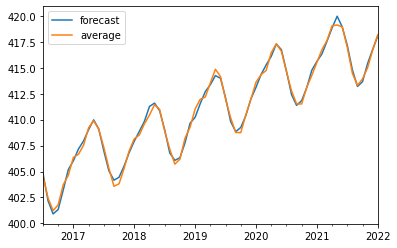

In [107]:
# ARIMA
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(co2.average, order=(10, 2, 3)) 
# p: No of lag observations.
# d: No of times that the raw observations are differenced.
# q: the size of the moving average window
results_ARIMA = model.fit()
results_ARIMA.summary()
results_ARIMA.plot_predict(start=700)
plt.show()